#### Importations

In [105]:
import os
import librosa
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_selection import SelectKBest, f_classif

In [59]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

In [64]:
# Créer un dictionnaire vide pour stocker les données audio pour chaque genre
audio_files = {}

# Itérer sur la liste des genres
for g in genres:
    # Créer une liste vide pour stocker les données audio pour le genre actuel
    audio_files[g] = []

    # Itérer sur les fichiers audio dans le répertoire pour le genre actuel
    for audio in os.listdir(f'../Data/genres_original/{g}'):
        # Charger les données audio en utilisant librosa et les ajouter à la liste pour le genre actuel
        audio_data = librosa.load(f'../Data/genres_original/{g}/{audio}')[0]
        audio_files[g].append(audio_data)

In [65]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

In [66]:
df = pd.DataFrame(columns = column_names)

In [67]:
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label


In [68]:
def audio_pipeline(audio: np.ndarray) -> List[float]:
  features = []

  # Calcul du ZCR
  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid
  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point
  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC
  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))
  return features

In [70]:
i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1


In [71]:
df.to_csv("./result.csv", index=False)

In [72]:
selector = VarianceThreshold(threshold=(8.0))
selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                                              'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                                              'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                                              'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']])

df_select = pd.DataFrame(selected_features)

Text(0.5, -0.15, 'Matrice de corrélation')

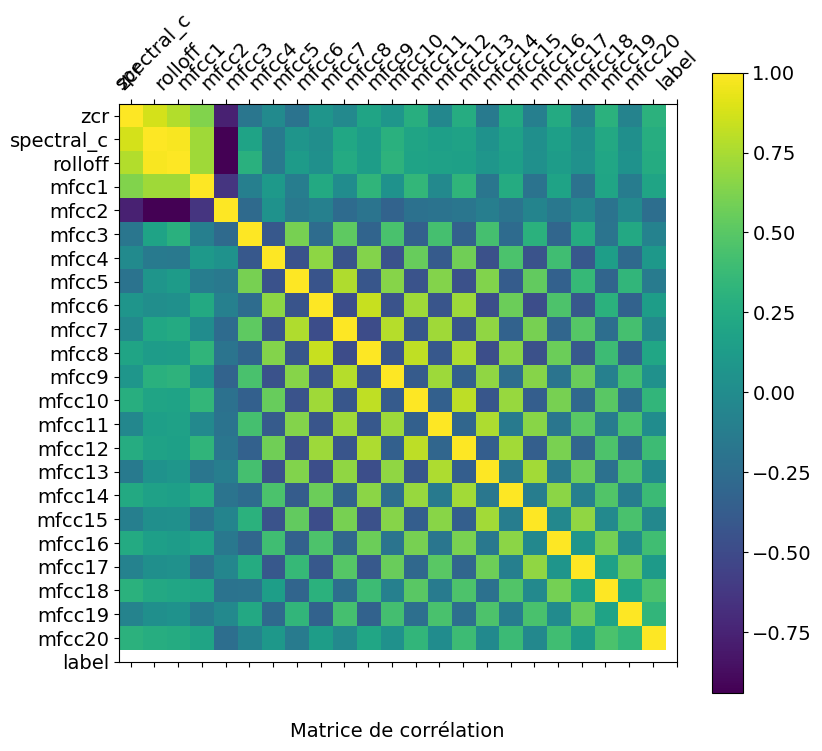

In [73]:
f = plt.figure(figsize=(9, 8))
#ax = plt.gca()
plt.matshow(df_select.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
#ax.tick_params(axis="x", bottom=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matrice de corrélation', fontsize=14, y=-0.15)

In [74]:
df.head()

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,55032,1784.122641,3805.723030,-113.598824,121.570671,-19.162262,42.363937,-6.362266,18.621931,-13.699734,...,8.802088,-3.669941,5.744675,-5.162783,0.751707,-1.687854,-0.408730,-2.302677,1.222467,blues
1,37140,1530.261767,3550.713616,-207.523834,123.985138,8.947019,35.867149,2.909595,21.519472,-8.556513,...,5.377876,-2.234492,4.220704,-6.010686,0.929294,-0.728403,0.296872,-0.282430,0.530644,blues
2,50564,1552.832481,3042.410115,-90.757164,140.440872,-29.084547,31.686693,-13.976547,25.753752,-13.664990,...,5.791247,-8.901966,-1.080160,-9.226245,2.448304,-7.724839,-1.819024,-3.440458,-2.238128,blues
3,22078,1070.153418,2184.879029,-199.575134,150.086105,5.663404,26.855278,1.770071,14.232647,-4.827845,...,6.078082,-2.478445,-1.081587,-2.874454,0.773994,-3.324069,0.636311,-0.615968,-3.405046,blues
4,67226,1835.128513,3579.957471,-160.354172,126.209480,-35.581394,22.139256,-32.473549,10.850701,-23.350071,...,-2.810499,-6.934471,-7.553875,-9.167669,-4.515863,-5.451786,-0.915952,-4.408018,-11.704385,blues


In [139]:
# Sélection des caractéristiques
features = df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                                              'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                                              'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                                              'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']]

In [140]:
# Labels (remplacez 'label' par le nom de votre colonne de labels)
labels = df['label']

In [141]:
labels.head()

0    blues
1    blues
2    blues
3    blues
4    blues
Name: label, dtype: object

In [142]:
num_classes = len(df['label'].unique())

In [143]:
# Convertir les labels en valeurs numériques si ce n'est pas déjà fait
# Par exemple, en utilisant pd.Categorical
labels = pd.Categorical(labels).codes

In [144]:
# Affichage des premiers labels pour vérifier
print(labels[:10])

[0 0 0 0 0 0 0 0 0 0]


In [145]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [146]:
# Conversion des données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [147]:
print("Dimensions de X_train_tensor:", X_train_tensor.shape)
print("Dimensions de y_train_tensor:", y_train_tensor.shape)
print("Dimensions de X_test_tensor:", X_test_tensor.shape)
print("Dimensions de y_test_tensor:", y_test_tensor.shape)


Dimensions de X_train_tensor: torch.Size([800, 23])
Dimensions de y_train_tensor: torch.Size([800])
Dimensions de X_test_tensor: torch.Size([200, 23])
Dimensions de y_test_tensor: torch.Size([200])


In [170]:
# Création de datasets et dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

In [171]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


In [176]:
model = SimpleNeuralNet(input_size=X_train.shape[1], hidden_size1=50, hidden_size2 = 30, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [177]:
train_losses = []
val_losses = []
num_epochs = 500

for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/500], Loss: 361.8308
Epoch [2/500], Loss: 146.2271
Epoch [3/500], Loss: 68.3375
Epoch [4/500], Loss: 38.8679
Epoch [5/500], Loss: 45.0265
Epoch [6/500], Loss: 58.0059
Epoch [7/500], Loss: 50.8189
Epoch [8/500], Loss: 48.0357
Epoch [9/500], Loss: 52.8203
Epoch [10/500], Loss: 47.9145
Epoch [11/500], Loss: 37.8547
Epoch [12/500], Loss: 27.7289
Epoch [13/500], Loss: 18.1777
Epoch [14/500], Loss: 40.9352
Epoch [15/500], Loss: 30.7323
Epoch [16/500], Loss: 25.2764
Epoch [17/500], Loss: 20.4570
Epoch [18/500], Loss: 34.7393
Epoch [19/500], Loss: 27.2608
Epoch [20/500], Loss: 49.3212
Epoch [21/500], Loss: 35.9887
Epoch [22/500], Loss: 36.5961
Epoch [23/500], Loss: 32.0142
Epoch [24/500], Loss: 32.9934
Epoch [25/500], Loss: 48.3346
Epoch [26/500], Loss: 36.2073
Epoch [27/500], Loss: 19.3093
Epoch [28/500], Loss: 33.8646
Epoch [29/500], Loss: 18.8691
Epoch [30/500], Loss: 30.7546
Epoch [31/500], Loss: 45.2686
Epoch [32/500], Loss: 23.5930
Epoch [33/500], Loss: 36.5383
Epoch [34/500], L

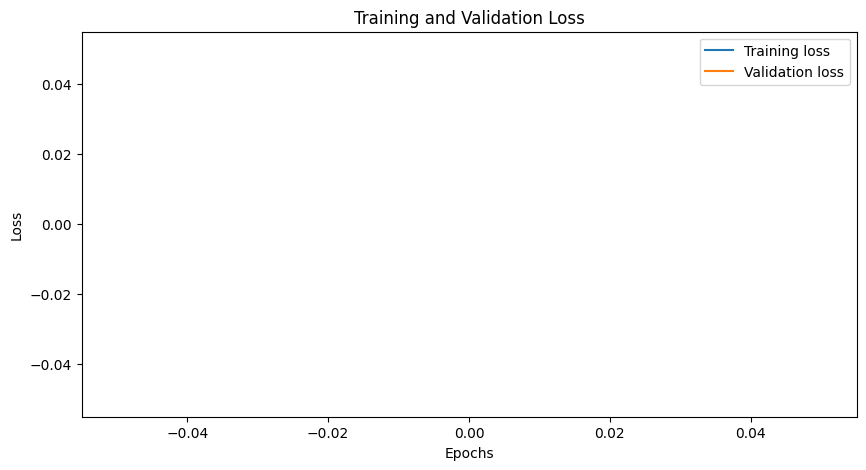

In [178]:
# Tracé des courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [179]:
model.eval()  # Mode d'évaluation
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the test data: {} %'.format(100 * correct / total))


Accuracy of the model on the test data: 35.5 %


In [181]:
train_losses = []
val_losses = []
num_epochs = 500

for epoch in range(num_epochs):
    model.train()  # Mettre le modèle en mode d'entraînement
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss.item())
    
    # Validation
    model.eval()  # Mettre le modèle en mode d'évaluation
    val_loss = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            val_loss += criterion(outputs, labels).item()
    
    val_losses.append(val_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss / len(test_loader):.4f}')


Epoch [1/500], Training Loss: 2.4014, Validation Loss: 3.0532
Epoch [2/500], Training Loss: 2.2133, Validation Loss: 3.8802
Epoch [3/500], Training Loss: 1.8940, Validation Loss: 2.7960
Epoch [4/500], Training Loss: 2.0204, Validation Loss: 2.7205
Epoch [5/500], Training Loss: 2.6864, Validation Loss: 3.5520
Epoch [6/500], Training Loss: 2.8747, Validation Loss: 7.4995
Epoch [7/500], Training Loss: 4.0661, Validation Loss: 5.5952
Epoch [8/500], Training Loss: 4.4690, Validation Loss: 8.0466
Epoch [9/500], Training Loss: 3.5197, Validation Loss: 10.9342
Epoch [10/500], Training Loss: 4.2440, Validation Loss: 3.3901
Epoch [11/500], Training Loss: 4.3352, Validation Loss: 6.2214
Epoch [12/500], Training Loss: 2.8638, Validation Loss: 3.3654
Epoch [13/500], Training Loss: 1.8944, Validation Loss: 2.5696
Epoch [14/500], Training Loss: 5.0384, Validation Loss: 2.9659
Epoch [15/500], Training Loss: 8.0614, Validation Loss: 3.7721
Epoch [16/500], Training Loss: 2.0063, Validation Loss: 4.9352


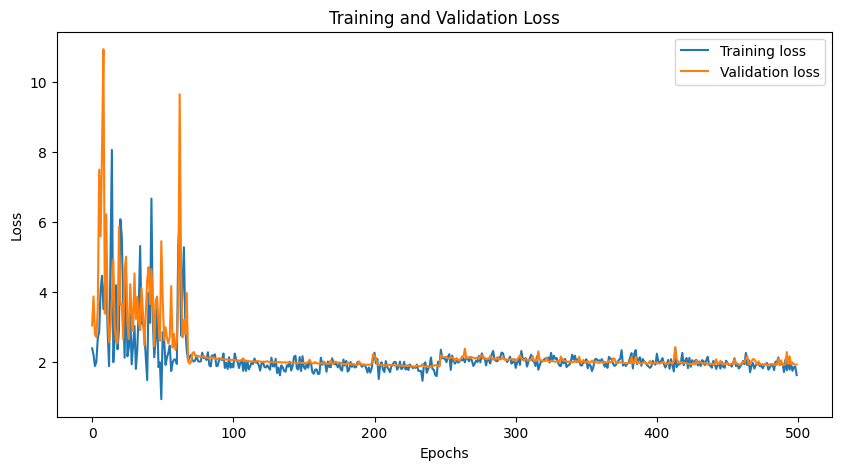

In [182]:
# Tracé des courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [190]:
# Enregistrement du modèle, ainsi que de son architecture
torch.save(model, "modelV1.pt")

In [191]:
# model = torch.load("modelV1.pt")